# Pré-processamento dos dados textuais

## Transformando os dados em um dataset

In [3]:
%pip -q install pandas
%pip -q install unidecode
%pip -q install nltk
%pip -q install sklearn
%pip -q install seaborn
%pip -q install yellowbrick

You should consider upgrading via the '/home/igor/Área de Trabalho/UFES/6 Período-EART/Data Science/TP/datascience_env/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/home/igor/Área de Trabalho/UFES/6 Período-EART/Data Science/TP/datascience_env/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/home/igor/Área de Trabalho/UFES/6 Período-EART/Data Science/TP/datascience_env/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/home/igor/Área de Trabalho/UFES/6 Período-EART/Data Science/TP/datascience_env/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/home/igor/Área d

In [4]:
import pandas as pd
import numpy as np

from scipy.cluster import hierarchy

import sklearn.metrics as metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

import seaborn as sns

#import limpeza dos dados
import nltk
import unidecode
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [5]:

df_base = pd.read_json('goodreads_books.json')
n_samples = 1000

#df_mini = df_base.sample(n=n_samples, random_state=1)
#df_mini.head()

In [6]:
df_mini = pd.DataFrame(data=None, columns=df_base.columns)
PER_GENRE = 1000
for g in df_base['genre'].unique():
    aux_df = df_base[df_base.genre == g].sample(PER_GENRE, random_state=7)
    df_mini = pd.concat([df_mini, aux_df], axis=0)
df_mini.head()

,book_id,description,genre,language_code
29584,27237230,"Laureate na nOg Eoin Colfer, author of the bes...",children,eng
27290,30267927,DreamWorks Animation's TROLLS is an irreverent...,children,eng
8046,16250909,Yoko and her mama are going on a trip to Japan...,children,eng
28484,17428684,Minnie and friends get ready to pamper their p...,children,eng
31456,30135659,One summer's day. ten-year-old India Opal Bulo...,children,eng


In [7]:
str_labels = df_mini['genre'].unique()
dict_labels = {str_labels[l] :  l for l in range(len(str_labels))}
convert = lambda x: dict_labels[x]
df_mini['labels_numeric'] = df_mini['genre'].apply(convert)
df_mini['genre'].value_counts()

children                  1000
comics_graphic            1000
fantasy_paranormal        1000
history_biography         1000
mystery_thriller_crime    1000
poetry                    1000
romance                   1000
young_adult               1000
Name: genre, dtype: int64

## Limpeza dos dados

In [8]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/igor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/igor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/igor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/igor/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [9]:
def remove_specials(tokens):
    return [unidecode.unidecode(word) for word in tokens]

def remove_punctuation(tokens):
    table = str.maketrans("","",string.punctuation)
    return [w.translate(table) for w in tokens]

def array_lower(tokens):
    return [w.lower() for w in tokens]

def remove_no_words(tokens):
    return [word for word in tokens if word.isalpha()]

def remove_stop_words(tokens):
    stop_words = set(stopwords.words('english'))
    return [w for w in tokens if not w in stop_words]

def text_clean(df_text_column, log=False):
    if log: print("Starting")

    # Dividindo texto em tokens
    df_text_column = df_text_column.apply(word_tokenize)

    if log: print("Tokens split done")  # Some log

    # Convertendo texto para minusculo
    df_text_column = df_text_column.apply(array_lower)

    if log: print("Upper letters converted to normal")

    # Removendo pontuação
    df_text_column = df_text_column.apply(remove_punctuation)

    if log: print("Removed punctiation")

    # Removendo caracteres especiais
    df_text_column = df_text_column.apply(remove_specials)

    if log: print("Specials chars removed")

    # Removendo tokens que não sao palavras
    df_text_column = df_text_column.apply(remove_no_words)

    if log: print("Removed non-words tokens")

    # Removendo tokens que são stop words
    df_text_column = df_text_column.apply(remove_stop_words)

    if log: print("Removed tokens that are stop-words\nFinished")

    return df_text_column


In [10]:
# Auxiliar log function
def size_df(d):
    print("Size=", d.memory_usage(deep=True).sum()/10**9, "GB")

In [11]:
df_mini['description'] = text_clean(df_mini['description'])
df_mini.head()

,book_id,description,genre,language_code,labels_numeric
29584,27237230,"[laureate, na, nog, eoin, colfer, author, best...",children,eng,0
27290,30267927,"[dreamworks, animation, trolls, irreverent, co...",children,eng,0
8046,16250909,"[yoko, mama, going, trip, japan, yoko, helps, ...",children,eng,0
28484,17428684,"[minnie, friends, get, ready, pamper, pets, mi...",children,eng,0
31456,30135659,"[one, summer, day, tenyearold, india, opal, bu...",children,eng,0


In [12]:
# df_base.loc[51285, 'description'] # Noisy data

# Lemmazation
Instead of Stemming who reduce inflexions to your base word we could use instead the Lemmazation approuch which groups differented inflexions form of a word

<h2 style="color:#ff3344">Observation</h2>
<span>The code above was converted to a raw cell in order to don't execute until we have a proof that <b>Lemmazation</b> is useful</span>

# Stemming

In [13]:
porter = PorterStemmer()
stemmized = lambda d: [porter.stem(tk) for tk in d]
df_mini['description'] = df_mini['description'].apply(stemmized)
df_mini.head()

,book_id,description,genre,language_code,labels_numeric
29584,27237230,"[laureat, na, nog, eoin, colfer, author, bests...",children,eng,0
27290,30267927,"[dreamwork, anim, troll, irrever, comedi, extr...",children,eng,0
8046,16250909,"[yoko, mama, go, trip, japan, yoko, help, mama...",children,eng,0
28484,17428684,"[minni, friend, get, readi, pamper, pet, minni...",children,eng,0
31456,30135659,"[one, summer, day, tenyearold, india, opal, bu...",children,eng,0


# TFIDF


### Using the hand made preprocessor

In [14]:
do_nothing = lambda x: x
vect_manual = TfidfVectorizer(tokenizer=do_nothing, lowercase=False, preprocessor=do_nothing, ngram_range=(1, 1))
freq = vect_manual.fit_transform(df_mini['description'].values.tolist())
features = vect_manual.get_feature_names_out()
df_freq = pd.DataFrame(data=freq.todense(), columns=features)
df_freq.head()

,aa,aaa,aacchmiiwanphsaanrwmepnhnuengaid,aachyaakrrmaehngkrmtamrwcch,aah,aamir,aan,aang,aanslag,aantal,...,zvezd,zwei,zweibel,zweilt,zwerg,zwicki,zylan,zylar,zyzzyva,zz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# PCA

In [15]:
N_COMPONENTS = 300
DESIRED_COVARIANCE = 0.95
pca = TruncatedSVD(n_components=N_COMPONENTS)

In [16]:
pca.fit(df_freq)
print(f"Total variance explained: {np.sum(pca.explained_variance_ratio_):.2f}")

Total variance explained: 0.21


In [17]:
freq_reduced = pca.transform(df_freq)
N_COMPONENTS = freq_reduced.shape[1]
df_freq_reduced = pd.DataFrame(data=freq_reduced, columns=list(range(N_COMPONENTS)))
df_freq_reduced.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.117638,0.162236,-0.009209,0.062237,-0.013662,0.019004,-0.031342,0.052993,0.022963,-0.049246,...,-0.020081,-0.000417,-0.009015,0.026794,0.017598,0.018930,-0.005863,0.000085,-0.025988,-0.014739
1,0.070044,0.020403,-0.027361,0.041986,0.018132,-0.017348,-0.040594,0.017676,-0.011521,-0.013544,...,0.009133,-0.012984,0.029323,-0.010737,0.003054,-0.008502,-0.003481,0.005834,0.021425,-0.017525
2,0.065638,-0.002124,0.015970,0.047547,-0.003921,-0.006985,-0.003368,0.003093,-0.017409,-0.019143,...,0.018373,-0.038953,0.006734,-0.006197,-0.003221,-0.000802,0.007827,0.005002,0.010678,0.009990
3,0.064464,0.017140,0.019037,0.088098,0.000520,0.013734,-0.042229,0.018203,-0.038256,-0.022162,...,0.027724,-0.010900,0.011936,-0.029602,-0.000188,0.014952,0.009778,0.011086,-0.010968,0.030713
4,0.076049,-0.025692,0.009320,0.019374,-0.025324,0.012558,-0.052892,0.002657,0.015259,0.014139,...,0.009426,0.007362,-0.014441,-0.007202,-0.011187,-0.004541,0.022541,-0.027624,-0.001187,0.015231


In [18]:
#scaler = StandardScaler(with_mean=True, with_std=True)
#df_freq_reduced[df_freq_reduced.columns] = scaler.fit_transform(df_freq_reduced)
#df_freq_reduced.head()

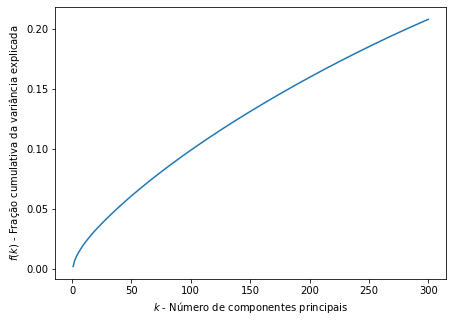

In [19]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(7, 5))
plt.plot([i for i in range(1, N_COMPONENTS + 1)], np.cumsum(pca.explained_variance_ratio_))
plt.xlabel(r'$k$ - Número de componentes principais')
plt.ylabel(r'$f(k)$ - Fração cumulativa da variância explicada');

Aplicando o número máximo de componentes principais percebemos que talvez seja preciso um aumento no número de samples uma vez que o valor de componentes principais deve estar no intervalo entre
$$\left[0, \ min(n_{samples} \ , \ n_{features}) \right]$$

# Analise da Quantidade de Grupos

## Elbow Method

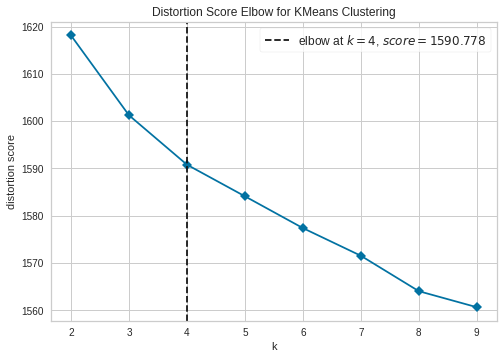

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [20]:
from yellowbrick.cluster import KElbowVisualizer
seed = 1
model = KMeans(init='k-means++', random_state = seed)
#model = AgglomerativeClustering(linkage = 'ward')
#model = SpectralClustering(affinity = 'nearest_neighbors', n_neighbors = 10)

visualizer = KElbowVisualizer(model, k=(2,10), timings=False)
visualizer.fit(df_freq_reduced.values)
visualizer.show()


# K-means

In [21]:
num_labels = df_mini['genre'].unique().size
print(num_labels)

8


In [22]:
N_CLUSTERS = 4
model = KMeans(n_clusters=N_CLUSTERS, random_state=42)
y_pred_k_means = model.fit_predict(df_freq_reduced)
# word_positions = {v: k for k, v in vectorizer.vocabulary_.items()}
# cluster_ids = generate_wordclouds(X_svd, X_tfidf, 2, word_positions)
y_pred_k_means

array([0, 2, 2, ..., 2, 2, 3], dtype=int32)

<AxesSubplot:>

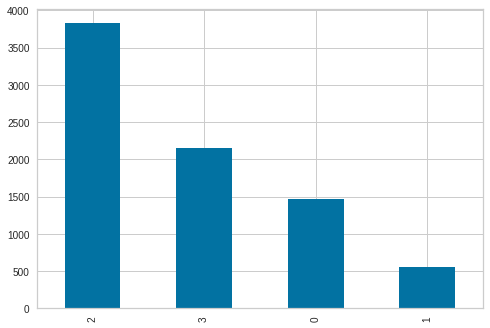

In [23]:
df_mini['pred_k_means'] = y_pred_k_means

df_mini['pred_k_means'].value_counts().plot(kind = 'bar')

# Agrupamento Hierarquico

In [24]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(N_CLUSTERS, linkage = 'ward')
y_pred_ah = model.fit_predict(df_freq_reduced)
y_pred_ah

array([0, 0, 0, ..., 0, 2, 2])

<AxesSubplot:>

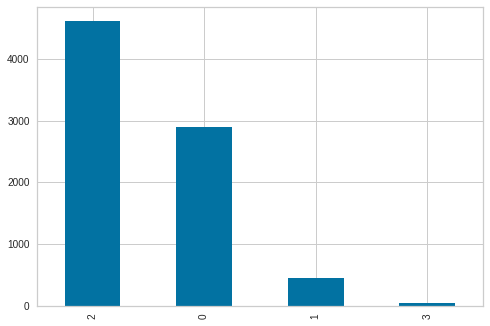

In [25]:
df_mini['y_pred_ah'] = y_pred_ah

df_mini['y_pred_ah'].value_counts().plot(kind = 'bar')

# Agrupamento Espectral

In [26]:
from sklearn.cluster import SpectralClustering

model = SpectralClustering(n_clusters = N_CLUSTERS, affinity = 'nearest_neighbors', n_neighbors = 10)
y_pred_sp = model.fit_predict(df_freq_reduced)
y_pred_sp

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

<AxesSubplot:>

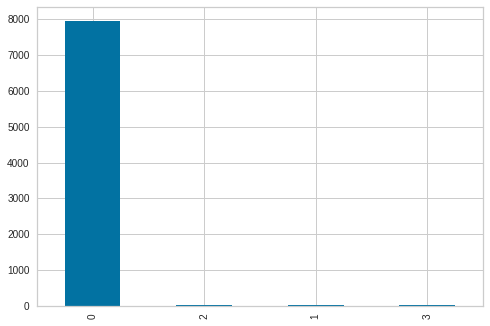

In [27]:
df_mini['y_pred_sp'] = y_pred_sp

df_mini['y_pred_sp'].value_counts().plot(kind = 'bar')

# Evaluate our model

[Text(0.5, 0, 'Cluster Number')]

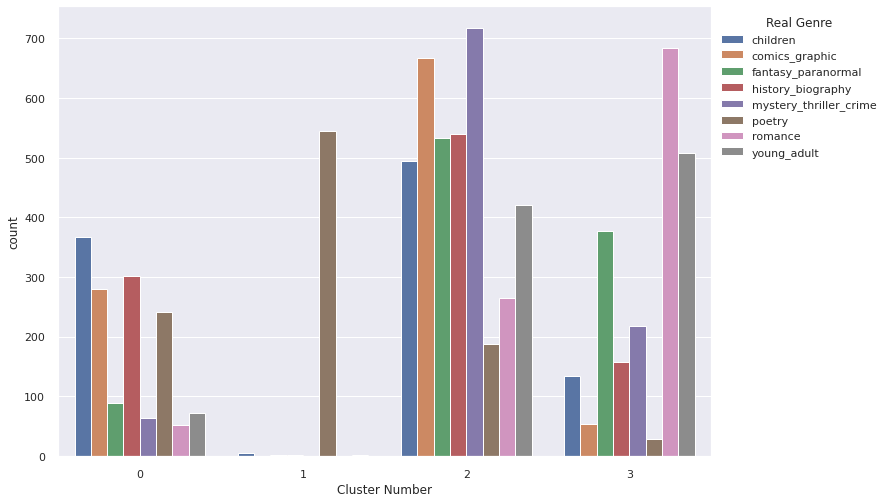

In [28]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
p = sns.countplot(data=df_mini, x='pred_k_means', hue='genre')
p.legend(title='Real Genre', bbox_to_anchor=(1, 1), loc='upper left')
p.set(xlabel='Cluster Number')

In [31]:
from sklearn.metrics import homogeneity_score, completeness_score
print("Homogeneity: ", homogeneity_score(df_mini['labels_numeric'].values, y_pred_k_means))
print("completeness_score: ", completeness_score(df_mini['labels_numeric'].values, y_pred_k_means))

Homogeneity:  0.1440534811847118
completeness_score:  0.2492689982966683


In [33]:
from sklearn.manifold import TSNE
tsne = TSNE(verbose=1, perplexity=50)
# The entry will be the TFIDF
X_red = tsne.fit_transform(df_freq.values)

/home/igor/Área de Trabalho/UFES/6 Período-EART/Data Science/TP/datascience_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/igor/Área de Trabalho/UFES/6 Período-EART/Data Science/TP/datascience_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.141s...
[t-SNE] Computed neighbors for 8000 samples in 35.267s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 0.238035
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.922729
[t-SNE] KL divergence after 1000 iterations: 3.208962


/home/igor/Área de Trabalho/UFES/6 Período-EART/Data Science/TP/datascience_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


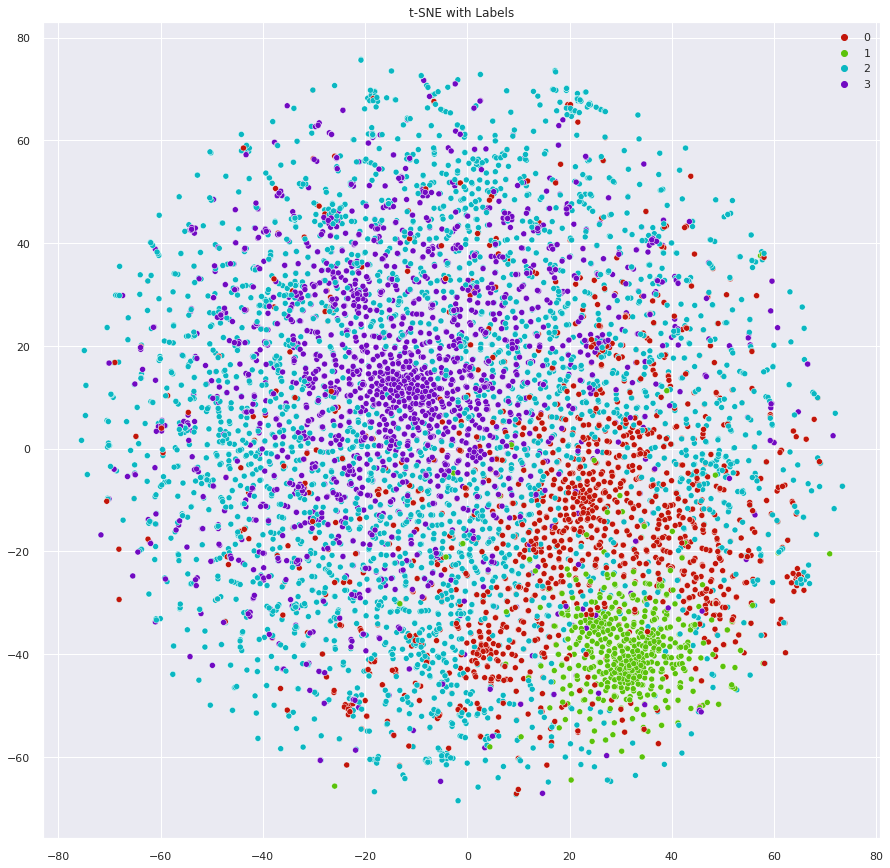

In [37]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(N_CLUSTERS, l=.4, s=.9)

# plot
sns.scatterplot(X_red[:,0], X_red[:,1], palette=palette, hue=y_pred_k_means, legend='full')
plt.title('t-SNE with Labels')
plt.savefig("t-sne_good_reads.png")
plt.show()